In [1]:
# imports the necessary requirements
from langchain_openai import ChatOpenAI
import pm4py
import duckdb
import os
from crewai import Agent, Task, Crew
# Importing crewAI tools
from crewai_tools import (
    DirectoryReadTool,
    FileReadTool,
    SerperDevTool,
    WebsiteSearchTool
)
#import pickle

In [2]:
# sets the API key (always needed!)
os.environ["OPENAI_API_KEY"] = open("api_key.txt", "r").read()

# sets the address of the APIs and the required model

# DeepInfra Qwen2-7B-Instruct
#llm = ChatOpenAI(model="Qwen/Qwen2-7B-Instruct", base_url="https://api.deepinfra.com/v1/openai/")

# OpenAI's GPT-4o Mini model 
llm = ChatOpenAI(model="gpt-4o-mini", base_url="https://api.openai.com/v1")

# OpenAI's GPT-3.5-turbo
#llm = ChatOpenAI(model="gpt-3.5-turbo", base_url="https://api.openai.com/v1")

FileNotFoundError: [Errno 2] No such file or directory: 'api_key.txt'

In [3]:
# reads the event log in-memory using pm4py
log = pm4py.read_xes("log02_06.xes")


# computes the DFG abstraction
dfg_abstraction = pm4py.llm.abstract_dfg(log)

parsing log, completed traces ::   0%|          | 0/5 [00:00<?, ?it/s]

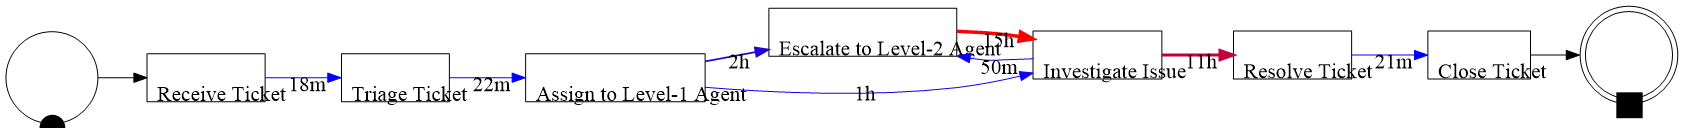

In [4]:

from pm4py.visualization.dfg import visualizer as dfg_visualizer

performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log)
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

In [5]:
print(dfg_abstraction)

If I have a process with flow:

Triage Ticket -> Assign to Level-1 Agent ( frequency = 5  performance = 1320.000 )
Resolve Ticket -> Close Ticket ( frequency = 5  performance = 1260.000 )
Receive Ticket -> Triage Ticket ( frequency = 5  performance = 1080.000 )
Investigate Issue -> Resolve Ticket ( frequency = 5  performance = 42120.000 )
Assign to Level-1 Agent -> Investigate Issue ( frequency = 4  performance = 4125.000 )
Escalate to Level-2 Agent -> Investigate Issue ( frequency = 2  performance = 54900.000 )
Investigate Issue -> Escalate to Level-2 Agent ( frequency = 1  performance = 3000.000 )
Assign to Level-1 Agent -> Escalate to Level-2 Agent ( frequency = 1  performance = 9000.000 )





In [6]:
# 2. Estatísticas gerais
from pm4py.stats import (
    get_start_activities,
    get_end_activities,
    get_event_attributes,
    get_trace_attributes,
    get_event_attribute_values,
    get_trace_attribute_values,
    get_variants,
    get_all_case_durations,
    get_cycle_time
)

In [ ]:
# 5. Duração de casos
durations = get_all_case_durations(log)   # dict: case_id → duração em segundos

print(f"→ Duração (s): min={min(durations):.0f}, max={max(durations):.0f}, "
      f"média={sum(durations)/len(durations):.0f}")


# 3. Normaliza para lista de tuplas (case_id, duration)
if durations and isinstance(durations[0], tuple):
    case_durs = durations
else:
    # extrai os IDs dos traces (assume atributo 'concept:name')
    case_ids = [trace.attributes.get("concept:name", f"trace_{i}") 
                for i, trace in enumerate(log)]
    case_durs = list(zip(case_ids, durations))

# 4. Ordena por duração (descendente)
case_durs_sorted = sorted(case_durs, key=lambda x: x[1], reverse=True)

# 5. Exibe o Top-5 (ou outro N à sua escolha)
print("Top-5 casos mais longos:")
for case_id, dur in case_durs_sorted[:5]:
    horas = dur / 3600
    print(f"  • Caso {case_id}: {dur:.0f} s ({horas:.2f} h)")

→ Duração (s): min=4800, max=176700, média=73440


AttributeError: 'str' object has no attribute 'attributes'

In [18]:

from pm4py.discovery import discover_performance_dfg, discover_dfg
from pm4py.visualization.dfg import visualizer as dfg_vis

# 2. Descobre o DFG de frequência
dfg_freq, start_act, end_act = discover_dfg(log)
gviz_freq = dfg_vis.apply(
    dfg_freq,
    start_act,
    end_act,
    parameters={
        # opcional: você pode ajustar cores, formatos, etc.
        dfg_vis.Variants.FREQUENCY.value.Parameters.FORMAT: "png"
    }
)
dfg_vis.view(gviz_freq) 

TypeError: string indices must be integers, not 'str'

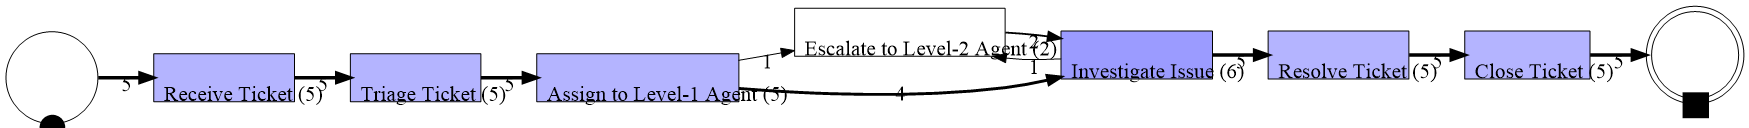

In [20]:
# 1) Grafo de frequência
dfg_freq, start_act, end_act = discover_dfg(log)

params_freq = {
    # formato de saída
    dfg_vis.Variants.FREQUENCY.value.Parameters.FORMAT: "png",
    # passa explicitamente os starts/ends (opcional: o visualizador já extrai do log por padrão)
    dfg_vis.Variants.FREQUENCY.value.Parameters.START_ACTIVITIES: start_act,
    dfg_vis.Variants.FREQUENCY.value.Parameters.END_ACTIVITIES: end_act
}

gviz_freq = dfg_vis.apply(
    dfg_freq,
    log=log,                      # seu log, para o visualizador poder contar atividades
    parameters=params_freq,
    variant=dfg_vis.Variants.FREQUENCY
)
dfg_vis.view(gviz_freq)

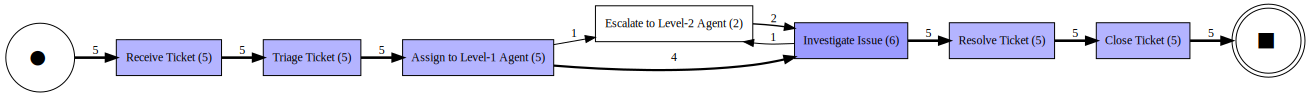

In [21]:
gviz_freq

In [23]:
params_freq

{<Parameters.FORMAT: 'format'>: 'png',
 <Parameters.START_ACTIVITIES: 'start_activities'>: {'Receive Ticket': 5},
 <Parameters.END_ACTIVITIES: 'end_activities'>: {'Close Ticket': 5}}

In [ ]:
import pm4py

# 1) Importar e ler o log XES
from pm4py.objects.log.importer.xes import factory as xes_importer
log = xes_importer.apply("path/to/log.xes")

In [37]:
from pm4py.conformance import (
    fitness_alignments,
    precision_alignments,
    fitness_footprints,
    precision_footprints
)

In [44]:
from pm4py.objects.log.importer.xes import factory as xes_importer
from pm4py.objects.conversion.log import factory as log_converter
import pandas as pd

ImportError: cannot import name 'factory' from 'pm4py.objects.log.importer.xes' (c:\Users\clovi\anaconda3\Lib\site-packages\pm4py\objects\log\importer\xes\__init__.py)

In [48]:
# 2) Descobre a Petri Net + marcações inicial/final
#    (Inductive Miner interno faz o processo tree → net para você)
net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log)  # :contentReference[oaicite:0]{index=0}


# 3) Fitness por alinhamentos
fitness_align = pm4py.fitness_alignments(log, net, initial_marking, final_marking)
print("Alignment-based fitness:", fitness_align)


# 5) Fitness e precision via Footprints
from pm4py.algo.discovery.footprints import algorithm as fp_discovery
from pm4py.algo.conformance.footprints import algorithm as fp_conformance
from pm4py.algo.conformance.footprints.util import evaluation as fp_evaluation

# 5.1) Descobre footprints
fp_log   = fp_discovery.apply(log, variant=fp_discovery.Variants.ENTIRE_EVENT_LOG)
fp_model = fp_discovery.apply(net, initial_marking, final_marking)

# 5.2) Conformance footprints
conf = fp_conformance.apply(fp_log, fp_model)

# 5.3) Achata e calcula métricas
flat_conf     = fp_evaluation.flatten_conf(conf)
flat_fp_log   = fp_evaluation.flatten_fp(fp_log)
flat_fp_model = fp_evaluation.flatten_fp(fp_model)

fitness_fap   = fp_evaluation.fp_fitness(flat_fp_log, flat_fp_model, flat_conf)
precision_fap = fp_evaluation.fp_precision(flat_fp_log, flat_fp_model)

print("Footprint-based fitness:", fitness_fap)
print("Footprint-based precision:", precision_fap)

aligning log, completed variants ::   0%|          | 0/3 [00:00<?, ?it/s]

Alignment-based fitness: {'percFitTraces': 100.0, 'averageFitness': 1.0, 'percentage_of_fitting_traces': 100.0, 'average_trace_fitness': 1.0, 'log_fitness': 0.9999920635550511}


TypeError: 'set' object is not subscriptable

In [40]:
from pm4py.statistics.overlap.cases.log import get as case_overlap_get

c:\Users\clovi\anaconda3\Lib\site-packages\pm4py\statistics\overlap\__init__.py:28: UserWarning: The overlap package will be removed in a future release.
  warnings.warn("The overlap package will be removed in a future release.")


In [50]:
wip = case_overlap_get.apply(log)
print(wip)



[5, 5, 5, 5, 5]


In [46]:
from pm4py.objects.conversion.log.variants.to_data_frame import apply as log_to_dataframe  # :contentReference[oaicite:0]{index=0}
import pandas as pd

# 2) Converte o EventLog em DataFrame
df = log_to_dataframe(log)

# 3) Calcula timestamp do próximo evento no mesmo caso
df["next_timestamp"] = df.groupby("case:concept:name")["time:timestamp"].shift(-1)

# 4) Duração em segundos de cada ocorrência de atividade
df["duration_secs"] = (df["next_timestamp"] - df["time:timestamp"]).dt.total_seconds()

# 5) Remove linhas sem duração (última atividade de cada caso)
df = df.dropna(subset=["duration_secs"])

# 6) Calcula média de duração por atividade
mean_dur = df.groupby("concept:name")["duration_secs"] \
             .mean() \
             .rename("mean_duration") \
             .reset_index()

# 7) Junta média no DataFrame e computa desvio absoluto
df = df.merge(mean_dur, on="concept:name")
df["abs_dev"] = (df["duration_secs"] - df["mean_duration"]).abs()

# 8) Para cada atividade, encontra o idx do maior desvio
idx_outliers = df.groupby("concept:name")["abs_dev"].idxmax()

# 9) Extrai as linhas “outliers”
outliers = df.loc[idx_outliers, [
    "concept:name",       # atividade
    "case:concept:name",  # case ID
    "duration_secs",      # duração observada
    "mean_duration",      # média da atividade
    "abs_dev"             # desvio absoluto máximo
]]

print(outliers)

                 concept:name case:concept:name  duration_secs  mean_duration  \
18    Assign to Level-1 Agent               104        12600.0         5100.0   
8   Escalate to Level-2 Agent               102         9000.0        54900.0   
14          Investigate Issue               103         1800.0        35600.0   
16             Receive Ticket               104         2400.0         1080.0   
20             Resolve Ticket               104         1800.0         1260.0   
1               Triage Ticket               101          600.0         1320.0   

    abs_dev  
18   7500.0  
8   45900.0  
14  33800.0  
16   1320.0  
20    540.0  
1     720.0  


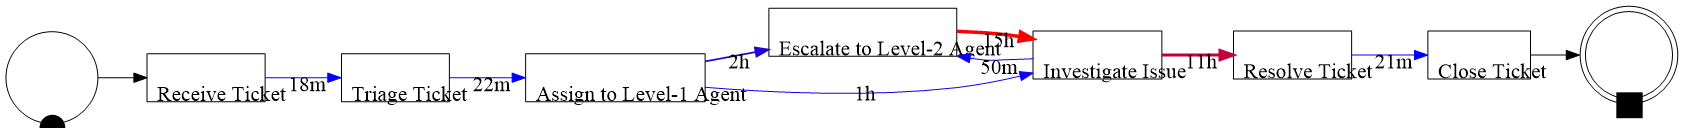

In [ ]:

from pm4py.visualization.dfg import visualizer as dfg_visualizer

performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log)
pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)